In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.chdir('G:\sources\AI_based_SE\AISE_fooling')

import torch
import random
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import random
import math

#from model import Model

import torch
print(torch.__version__)

debug = False

1.9.0+cu102


In [3]:
def show_image(arr):
    if 'cuda' in str(arr.device):
        arr = arr.cpu()
    plt.imshow(arr, cmap='gray')
    plt.show()

# TEST
# CUDA
# size = (28,28)
# a = torch.rand(size).cuda()
# show_image(a)

# CPU
if debug:
    a = torch.rand(28,28)
    show_image(a)

In [4]:
def recovery_image(arr):
    rand_num = torch.rand((28,28))/4

    d = c[0][0] + rand_num
    d[d<1/4] = 0

    return torch.reshape(d, (1,1,28,28))
    show_image(d)

In [5]:
def normalize(value):
    return value * 4 // 1 / 4

In [6]:
model_path = '/mnt/g/sources/AI_based_SE/AISE_fooling/models/mnist_0.9893.pkl'
model = torch.load(model_path)
#model_cuda = torch.load(model_path).cuda()

In [7]:
def generate_initial_image(norm=False, cuda=False, size=(28,28), batch_size=1):
    if cuda:
        image_arr = torch.rand(batch_size, size[0], size[1]).cuda()
    else:
        image_arr = torch.rand(batch_size, size[0], size[1])

    if norm:
        image_arr = normalize(image_arr) # * 4 // 1 / 4
    
    return image_arr

if debug:
    # CPU
    print(generate_initial_image(norm=True, cuda=False, size=(2,2), batch_size=2))
    
    # CUDA
    #print(generate_initial_image(norm=True, cuda=True, size=(2,2), batch_size=2))

In [8]:
def polynomial_mutate(value, cuda=False):
    strength = 15

    if cuda:
        u = torch.rand(value.shape).cuda()
        delta = torch.zeros(value.shape).cuda()
    else:
        u = torch.rand(value.shape)
        delta = torch.zeros(value.shape)

    delta[u<0.5] = (pow((u[u<0.5] * 2), (1.0 / strength + 1.0))) - 1
    delta[u>=0.5] = 1 - pow(2.0 * (1.0 - u[u>=0.5]), 1.0 / (strength + 1.0))
    
#     if u < 0.5:
#         delta = (pow((u * 2), (1.0 / strength + 1.0))) - 1
#     else:
#         delta = 1 - pow(2.0 * (1.0 - u), 1.0 / (strength + 1.0))

    delta[delta<0] = 0
    delta[delta>1] = 1
    
    result = value + delta
    return result

# TEST
if debug:
    batch_size = 64
    size = (28,28)
    # CUDA
#     a = torch.rand((batch_size, size[0], size[1]))#.cuda();
#     for i in range(5):
#         a = polynomial_mutate(a, cuda=True)
#         print(a[0][0][0])

    # CPU
    a = torch.rand((batch_size, size[0], size[1]));
    for i in range(5):
        a = polynomial_mutate(a, cuda=False)
        print(a[0][0][0])

In [9]:
def mutate(image_arr, mutate_rate, mutate_type='poly', norm=False, cuda=False, size=(28,28), batch_size=1):
    image_flatten = torch.reshape(image_arr, (batch_size * size[0] * size[1], 1))
    num_change = int(batch_size * size[0] * size[1] * mutate_rate)
    prob = torch.rand((batch_size * size[0] * size[1]))
    change_idx = torch.multinomial(prob, num_samples=num_change)
    
    if mutate_type == 'poly':
        image_flatten[change_idx] = polynomial_mutate(image_flatten[change_idx], cuda=cuda)
    if mutate_type == 'uniform':
        if cuda:
            image_flatten[change_idx] = torch.rand(len(image_flatten[change_idx]),1).cuda()
        else:
            image_flatten[change_idx] = torch.rand(len(image_flatten[change_idx]),1)
    
    image_arr = torch.reshape(image_flatten, (batch_size, size[0], size[1]))
    
    if norm:
        image_arr = normalize(image_arr)

    return image_arr

# TEST
if debug:
    batch_size = 64
    size = (28,28)
    
    # CUDA
    #a = torch.zeros(batch_size, size[0], size[1]).cuda()
    #print(mutate(a, 0.1, norm=False, cuda=True, size=size, batch_size=batch_size))
    
    # CPU - polynomial mutation
    a = torch.zeros(batch_size, size[0], size[1])
    print(a.shape, len(a[a!=0]))
    b = mutate(a, 0.1, norm=False, cuda=False, size=size, batch_size=batch_size)
    print(b.shape, len(b[b!=0]))
    
    # CPU - uniform mutation
    a = torch.zeros(batch_size, size[0], size[1])
    print(a.shape, len(a[a!=0]))
    b = mutate(a, 0.1, mutate_type='uniform', norm=False, cuda=False, size=size, batch_size=batch_size)
    print(b.shape, len(b[b!=0]))

In [10]:
def fitness_function(image_arr, label, cuda=False):
    image_arr = image_arr.unsqueeze(1)
    
    if cuda:
        predict_y = model_cuda(image_arr.float())
    else:
        predict_y = model(image_arr.float())

    pow_ = pow(math.e, predict_y)
    predict_y = pow_ / torch.sum(pow_)
    return predict_y[:,label]

# TEST
if debug:
    label=1
    batch_size = 64

    # CUDA
#     a = generate_initial_image(cuda=True)
#     y = fitness_function(a, 0, cuda=True)
#     show_image(a)
    
    # CPU
    a = generate_initial_image(cuda=False, batch_size=batch_size, norm=False)
    y = fitness_function(a, label, cuda=False)
    print(y.shape)
    print(f"precision : {y}")
    show_image(a[0])

In [11]:
def get_update_batches(batch_score, max_change=10):
    sorted_score, sorted_index = batch_score.sort()
    
    sorted_score = sorted_score[-max_change:]
    sorted_index = sorted_index[-max_change:]
    
    a = sorted_score!=0.0
    sorted_score = sorted_score[a]
    sorted_index = sorted_index[a]
    
    return sorted_score, sorted_index

#TEST
if debug:
    a = torch.zeros(5)
    print(get_update_batches(a, 2))

In [12]:
def get_lowest_batches(image_arr, choice_num):
    sorted_score, sorted_index = image_arr.sort()
    sorted_index = sorted_index[:choice_num]
    return sorted_index

#TEST
if debug:
    a = list(range(10))
    random.shuffle(a)
    a = torch.tensor(a)
    a_idx = get_lowest_batches(a, 3)
    print(a)
    print("idx :\t", a_idx)
    print("value :\t", a[a_idx])

In [19]:
# MAIN code

cuda = False
# cuda = True

mutate_type = 'poly'
#mutate_type = 'uniform'
########################################################

#iteration = 1000
iteration = 20000
batch_size = 64

mutate_rate_cutting_time = 1000
label = list(range(0,10))

#again_time = 100

best_image_arr_map = torch.zeros(len(label), 28, 28)
best_score_map = torch.zeros(len(label))


with torch.no_grad():
    for lab in label:
        best_score = 0
        mutate_rate = 0.1
        max_score = 0

        image_arr_batch = generate_initial_image(cuda=cuda, batch_size=batch_size)
        image_arr_score = torch.zeros(batch_size)

        t = trange(iteration, leave=True)
        for i in t:
            if i == mutate_rate_cutting_time:
                mutate_rate = mutate_rate / 2

            # Mutate
            image_arr_batch_new = mutate(image_arr_batch, mutate_rate, norm=True, cuda=cuda, batch_size=batch_size)

            # Fitness & sampling
            batch_score = fitness_function(image_arr_batch_new, lab, cuda=cuda)
            update_batch_score, update_batch_index = get_update_batches(batch_score)

            if len(update_batch_score) == 0:
                continue

            # Get updated batches
            candidate_num = len(update_batch_score)
            lowest_indices = get_lowest_batches(image_arr_score, candidate_num)

            # Update batches
            image_arr_batch[lowest_indices] = image_arr_batch_new[update_batch_index]
            image_arr_score[lowest_indices] = update_batch_score

            # Get max score
            max_idx = torch.argmax(update_batch_score)
            current_max_score = update_batch_score[max_idx]

            if max_score < current_max_score:
                max_score = current_max_score
            
            # Update tqdm
            t.set_description(f'label {lab}, current score : {max_score*100:2.2f}%\t')
            t.refresh() # to show immediately the update

            if max_score > 0.9999:
                best_image_arr_map[lab] = image_arr_batch[max_idx]
                best_score_map[lab] = max_score
                break
                
            #break #iteration
        show_image(best_image_arr_map[lab].unsqueeze(0).unsqueeze(0))
        
        #break #label

label 0, current score : 1e+02%	:  79%|███████▉  | 15859/20000 [01:27<00:22, 182.07it/s] 


KeyboardInterrupt: 

tensor(11.9385, grad_fn=<SelectBackward>)


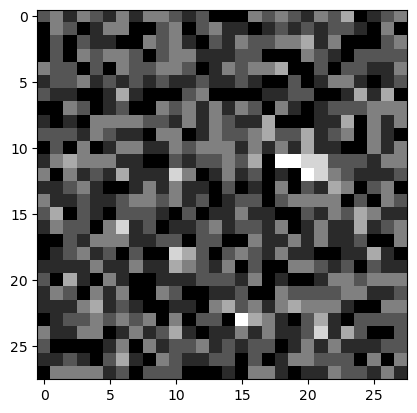

tensor(11.6386, grad_fn=<SelectBackward>)


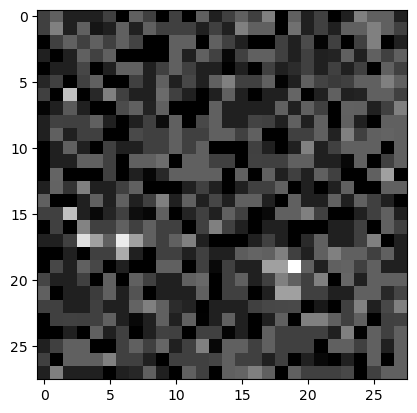

tensor(11.1356, grad_fn=<SelectBackward>)


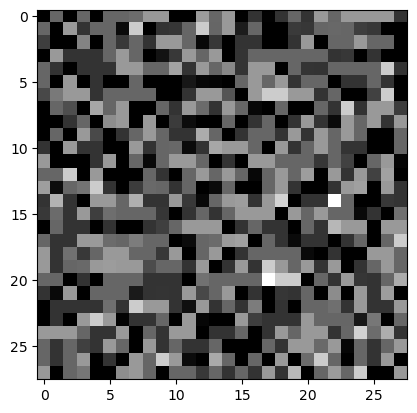

tensor(11.1794, grad_fn=<SelectBackward>)


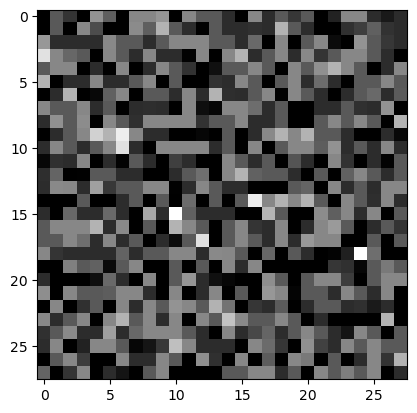

tensor(11.5535, grad_fn=<SelectBackward>)


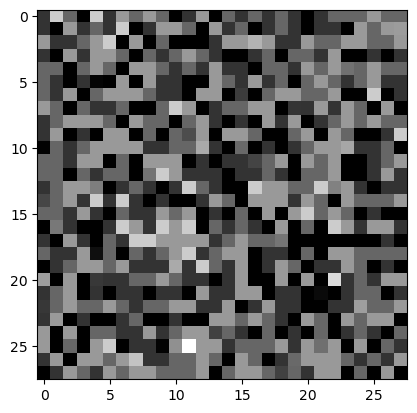

tensor(11.3310, grad_fn=<SelectBackward>)


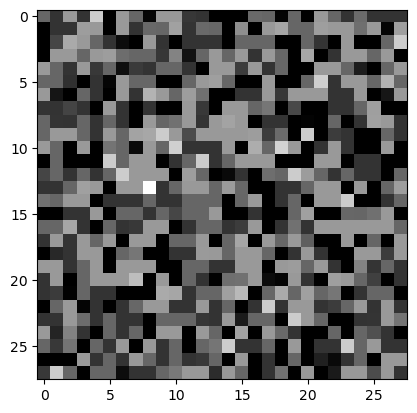

tensor(11.4626, grad_fn=<SelectBackward>)


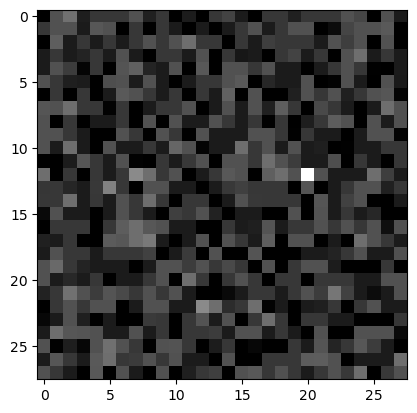

tensor(10.5406, grad_fn=<SelectBackward>)


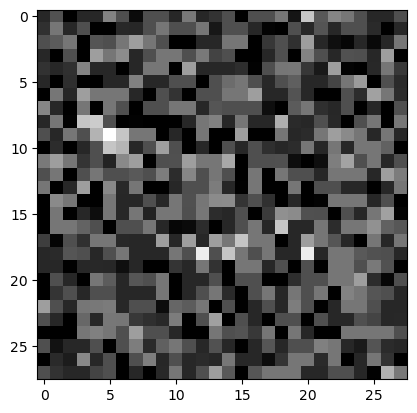

tensor(11.5597, grad_fn=<SelectBackward>)


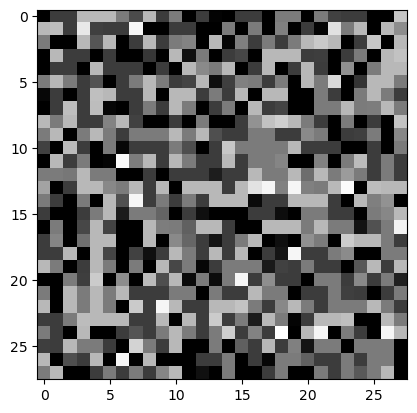

tensor(11.7634, grad_fn=<SelectBackward>)


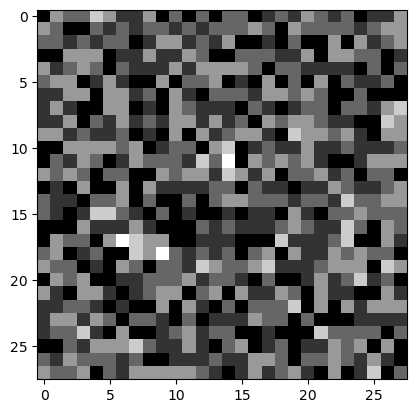

In [243]:
for lab, best_image_arr in enumerate(best_image_arr_map):
    y = model(best_image_arr.unsqueeze(0).unsqueeze(0))
    print(y[0][lab])
    show_image(best_image_arr)

In [244]:
best_score_map

tensor([105.7744, 117.4615, 116.2380, 101.8262, 158.6880, 100.9421, 105.5245,
        106.5039, 141.5537, 118.4143], grad_fn=<CopySlices>)